In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.095
config.gpu_options.visible_device_list = "1"
set_session(tf.Session(config=config))

import keras
from keras import backend as K
from keras.models import model_from_json

import json
import numpy as np
from skimage import transform

from skopt import Optimizer
from skopt.space import Real

/home/nexes/miniconda3/envs/tf_py3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
from mnist import load_dataset

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

all_data = np.vstack((X_train, X_val, X_test))
all_data = all_data.reshape(-1, 28, 28)

subsample_indices = np.random.choice(len(all_data), 2000, replace=False)

all_data = all_data[subsample_indices]

results_dict = dict()

In [7]:
def get_base_data(half_n_samples, alpha0=0):
    X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
    all_data = np.vstack((X_train, X_val, X_test))
    all_data = all_data.reshape(-1, 28, 28)
    subsample_indices = np.random.choice(len(all_data), half_n_samples, replace=False)

    all_data = all_data[subsample_indices]
    
    if alpha0 != 0:
        all_data = rotate_dataset(all_data, alpha0)
    return all_data


In [20]:
a = get_base_data(10, 0)

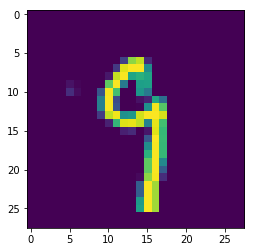

In [21]:
plt.imshow(a[0])

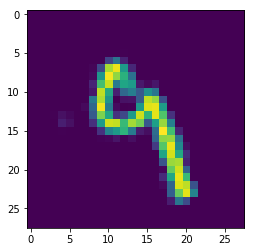

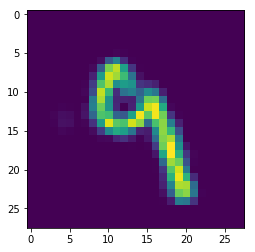

In [31]:
plt.figure()
plt.imshow(transform.rotate(a[0], 25 ))
b = transform.rotate(a[0], 10 )
plt.figure()
plt.imshow(transform.rotate(b, 15 ))

In [5]:
def rotate_dataset(dataset, angle):
    return np.array(list(map(lambda x: transform.rotate(x, angle), dataset)))

def get_X_and_y(dataset, angle):
    rotated_datased = rotate_dataset(dataset, angle)
    whole_dataset = np.vstack((dataset, rotated_datased)).reshape(-1, 784)
    shuffled_indices = np.arange(len(whole_dataset))
    np.random.shuffle(shuffled_indices)
    
    whole_dataset = whole_dataset[shuffled_indices]
    
    _labels = np.zeros(2*dataset.shape[0], dtype=bool)
    _labels[dataset.shape[0]:] = True
    _labels = _labels[:, None]
    
    whole_labels = np.array(np.hstack((_labels, ~_labels)), dtype=int)
    whole_labels = whole_labels[shuffled_indices]
    
    return whole_dataset, whole_labels

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
    return

def target_function(params):
    global results_dict
    alpha = params[0]
    
    reset_weights(model)
#     print('here')
    X, y = get_X_and_y(all_data, alpha)
    val_border = -int(np.floor(X.shape[0]/20))
    test_border = -int(np.floor(X.shape[0]/5))
    X_val, y_val = X[val_border:], y[val_border:]
    X_test, y_test = X[test_border:val_border], y[test_border:val_border]
    X, y = X[:test_border], y[:test_border]
    
    batch_size = 128
    epochs = 2
    history = model.fit(X, y,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        validation_data=(X_val, y_val))
    _logloss, _accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    target_score = np.log(2) - _logloss
    
    results_dict[alpha] = {
        'score': target_score,
        'model_weights': model.get_weights()
    }
#     print('there')
    return target_score

In [4]:
with open('model_architecture.json', 'r') as iofile:
    model_architecture = json.load(iofile)    
model = model_from_json(model_architecture)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [5]:
dimensions = [Real(name='alpha', low=-180.0, high=180.0)]
opt = Optimizer(dimensions=dimensions)

In [6]:
res = opt.run(target_function, 30)


In [10]:
import pickle
with open('optimizer_test_save.pcl', 'wb') as iofile:
    pickle.dump(opt, iofile)

In [14]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def visualise(optimizer):    
    points = np.linspace(-180, 180, 360).reshape(-1, 1)
    mu, sigma = optimizer.models[-1].predict(optimizer.space.transform(list(points)), return_std=True)
    
    plt.figure(figsize=(15, 10))
    plt.plot(points, mu, "r", label="Upper bound by classifier")
#     plt.plot(points, mu+sigma, "g--")
#     plt.plot(points, mu-sigma, "g--")
    plt.scatter(optimizer.Xi, optimizer.yi, c='b', label='sampled points')

    _x = np.concatenate((points, points[::-1]))
    _y = np.concatenate(([mu[i] - sigma[i] for i in range(len(points))], 
                            [mu[i] + sigma[i] for i in range(len(points)-1, -1, -1)]))
    plt.fill(_x, _y, fc='r', alpha=.2, ec=None, label='+- sigma range')
    
    plt.hlines(np.log(2), -180, 180, label='log2')
    plt.ylabel('log2 - logloss')
    plt.xlabel('angle')
    
    plt.xlim((-185, 185))
    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.show()

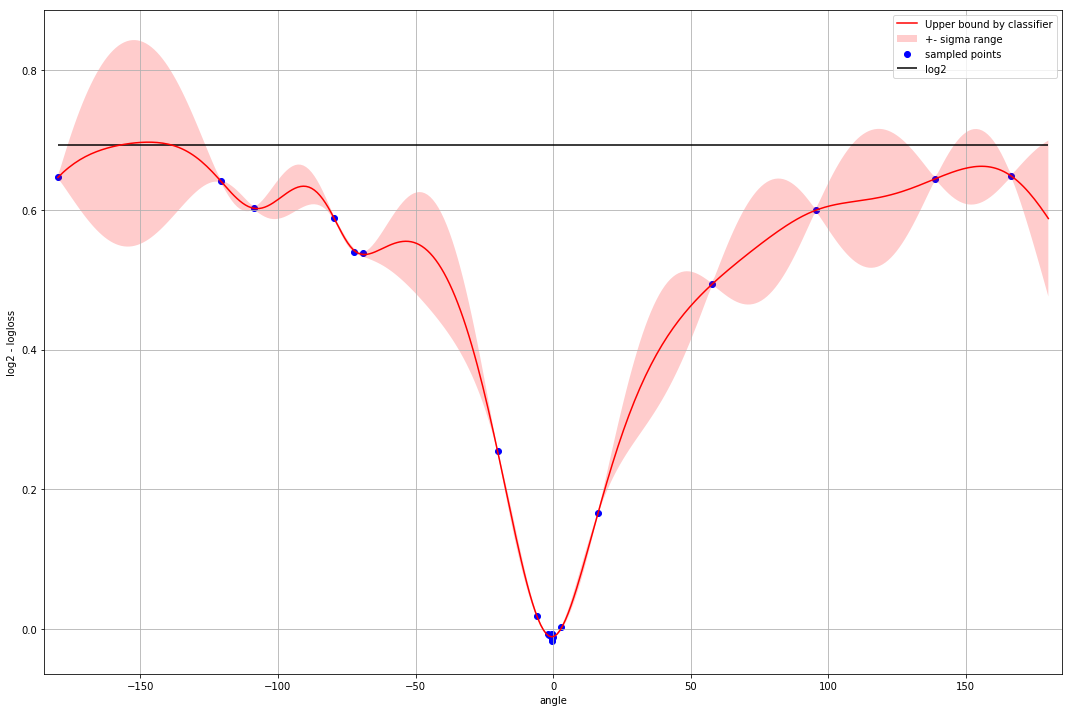

In [8]:
visualise(opt)

In [1]:
# import multiprocessing
# import subprocess

# def work(cmd):
#     return subprocess.call(cmd, shell=False)

# if __name__ == '__main__':
#     count = multiprocessing.cpu_count()
#     pool = multiprocessing.Pool(processes=count)
#     print(pool.map(work, ['ls'] * count))

In [17]:
import multiprocessing
import subprocess

def calculate(value):
    return value * 10

if __name__ == '__main__':
    pool = multiprocessing.Pool(10)
    tasks = range(10000)
    results = []
    r = pool.map_async(calculate, tasks, callback=results.append)
    r.wait() # Wait on the results
    print(results)

[[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310, 1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430, 1440, 1450, 1460, 1470, 1480, 1490, 1500, 1510, 1520, 1530, 1540, 1550, 1560, 1570, 1580, 1590, 1600, 1610, 1620, 1630, 1640, 1650, 1660, 1670, 1680, 1690, 1700, 1710, 1720, 1730, 1740, 1750, 1760, 1770, 1780, 1790, 1800, 1810, 1820, 1830, 1840,

In [11]:
import sys

if len(sys.argv) != 7:
    raise ValueError()

params = sys.argv[1:]
GPU_IDX = params[0]
n_steps = int(params[1])
n_initial_points = int(params[2])
n_epochs = int(params[3])
batch_size = int(params[4])
alpha0 = float(params[5])


import os
os.environ['OMP_NUM_THREADS'] = '1'
### configuring keras to use fixed part of GPU
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.095
config.gpu_options.visible_device_list = GPU_IDX
set_session(tf.Session(config=config))

import keras
from keras import backend as K
from keras.models import model_from_json

import json
import pickle

import numpy as np
from skimage import transform

from skopt import Optimizer
from skopt.space import Real

### Loading dataset
from mnist import load_dataset


def rotate_dataset(dataset, angle):
    return np.array(list(map(lambda x: transform.rotate(x, angle), dataset)))


def get_base_data(half_n_samples, alpha0=0):
    X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
    all_data = np.vstack((X_train, X_val, X_test))
    all_data = all_data.reshape(-1, 28, 28)
    subsample_indices = np.random.choice(len(all_data), half_n_samples, replace=False)

    all_data = all_data[subsample_indices]
    
    if alpha0 != 0:
        all_data = rotate_dataset(all_data, alpha0)
    return all_data


def get_X_and_y(base_dataset, target_dataset, angle):
    rotated_datased = rotate_dataset(base_dataset, angle)
    whole_dataset = np.vstack((target_dataset, rotated_datased)).reshape(-1, 784)
    shuffled_indices = np.arange(len(whole_dataset))
    np.random.shuffle(shuffled_indices)
    
    whole_dataset = whole_dataset[shuffled_indices]
    
    _labels = np.zeros(2*base_dataset.shape[0], dtype=bool)
    _labels[base_dataset.shape[0]:] = True
    _labels = _labels[:, None]
    
    whole_labels = np.array(np.hstack((_labels, ~_labels)), dtype=int)
    whole_labels = whole_labels[shuffled_indices]
    
    return whole_dataset, whole_labels


def load_model(path_to_model):
    with open(path_to_model, 'r') as iofile:
        model_architecture = json.load(iofile)    
    model = model_from_json(model_architecture)

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
    return


class myOptimizer:
    def __init__(self, 
                 dataset_size, 
                 alpha0=0,
                 n_epochs=5, 
                 batch_size=64, 
                 path_to_model='model_architecture.json'):
        self._dataset_size = dataset_size
        self._n_epochs = n_epochs
        self._batch_size = batch_size
        self._alpha0 = alpha0
        self.base_data = self._read_data()
        self.target_data = self._get_rotated_data()
        self.results_dict = dict()
        self.model = load_model(path_to_model)
    
    def _read_data(self):
        return get_base_data(self._dataset_size)
    
    def _get_rotated_data(self):
        return rotate_dataset(self.base_data, self._alpha0)
    
    def target_function(self, params):
        alpha = params[0]

        reset_weights(self.model)
    #     print('here')
        X, y = get_X_and_y(self.base_data, self.target_data, alpha)
        val_border = -int(np.floor(X.shape[0]/20))
        test_border = -int(np.floor(X.shape[0]/5))
        X_val, y_val = X[val_border:], y[val_border:]
        X_test, y_test = X[test_border:val_border], y[test_border:val_border]
        X, y = X[:test_border], y[:test_border]

        history = self.model.fit(X, y,
                            batch_size=self._batch_size,
                            epochs=self._n_epochs,
                            verbose=0,
                            validation_data=(X_val, y_val))
        _logloss, _accuracy = self.model.evaluate(X_test, y_test, verbose=0)

        target_score = np.log(2) - _logloss

        self.results_dict[alpha] = {
            'score': target_score,
            'model_weights': self.model.get_weights()
        }

        return target_score
    

if __name__ == '__main__':
    dimensions = [Real(name='alpha', low=-180.0, high=180.0)]
    
    for dataset_size in [2000, 3000, 5000, 10000, 20000, 35000, 70000]:
        opt = Optimizer(dimensions=dimensions, n_initial_points=n_initial_points)
        optimization_attempt = myOptimizer(dataset_size=dataset_size, 
                                           alpha0=alpha0,
                                           n_epochs=n_epochs, 
                                           batch_size=batch_size)
        res = opt.run(optimization_attempt.target_function, n_iter=n_steps)
        
        with open('{}_{}_start.pcl', 'wb') as iofile:
            save_dict = {
                'opt': opt,
                'alpha0': alpha0,
                'dataset_size': dataset_size,
                'results_dict': optimization_attempt.results_dict,
                'raw_sysargv_params': params
            }
            pickle.dump(save_dict, iofile)
        
        print('Process with alpha0 = {} finished with dataset size {}'.format(alpha0, dataset_size))

In [12]:
n_steps = 30
n_initial_points = 10
n_epochs = 5
batch_size = 64
alpha0 = 25


dimensions = [Real(name='alpha', low=-180.0, high=180.0)]

for dataset_size in [2000]:#, 3000, 5000, 10000, 20000, 35000, 70000]:
    opt = Optimizer(dimensions=dimensions, n_initial_points=n_initial_points)
    optimization_attempt = myOptimizer(dataset_size=dataset_size, 
                                       alpha0=alpha0,
                                       n_epochs=n_epochs, 
                                       batch_size=batch_size)
    res = opt.run(optimization_attempt.target_function, n_iter=n_steps)

    with open('{}_{}_start.pcl', 'wb') as iofile:
        save_dict = {
            'opt': opt,
            'alpha0': alpha0,
            'dataset_size': dataset_size,
            'results_dict': optimization_attempt.results_dict,
            'raw_sysargv_params': params
        }
        pickle.dump(save_dict, iofile)

    print('Process with alpha0 = {} finished with dataset size {}'.format(alpha0, dataset_size))

NameError: name 'params' is not defined

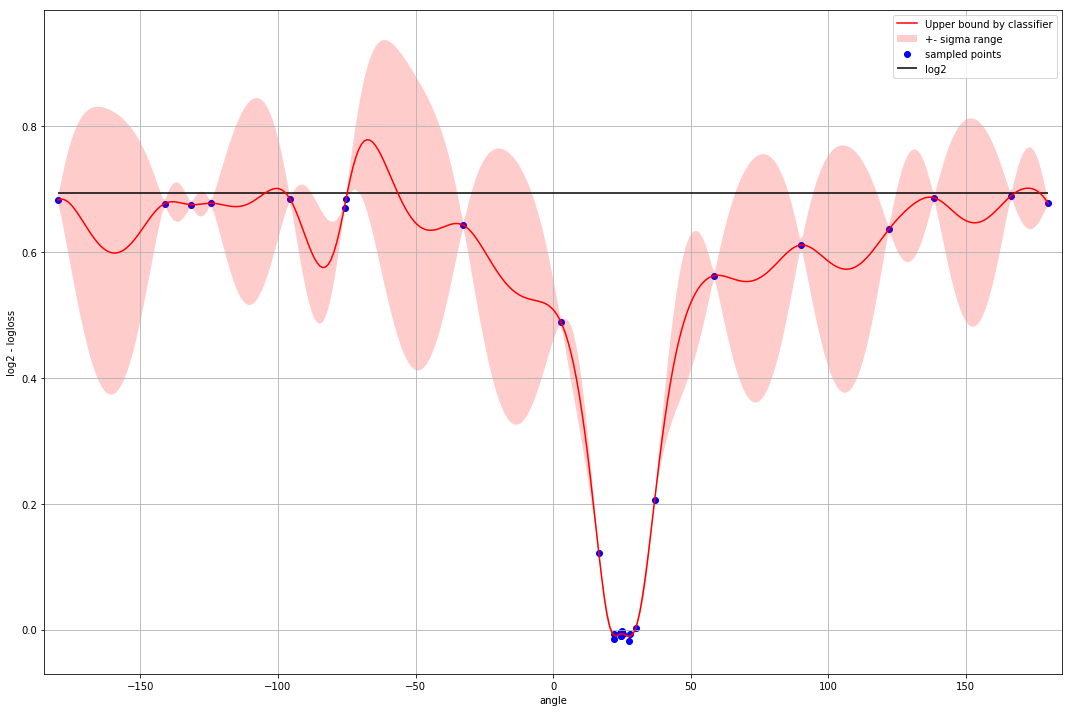

In [15]:
visualise(opt)